In [46]:
import pickle

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from xgboost import XGBRFClassifier

from sklearn.pipeline import Pipeline

from sklearn.metrics import classification_report

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

from yellowbrick.classifier import ConfusionMatrix, ROCAUC


# Import labeled data

In [2]:
labeled_df = pd.read_csv("../data/user_labeled/final_labeled.csv")
print(labeled_df.label.value_counts())
labeled_df

before    140
after     137
Name: label, dtype: int64


,node,label,degree,category_matches_with_source,in_edges,out_edges,shared_neighbors_with_entry_score,centrality,page_rank,adjusted_reciprocity,shortest_path_length_from_entry,shortest_path_length_to_entry,jaccard_similarity,primary_link,similarity_rank
0,Pitch contour,before,0.003537,0.500000,0.002191,0.013444,0.003673,0.004906,0.005235,0.032710,0.125000,0.4,0.002206,1.0,0.685813
1,Contrapuntal motion,before,0.001580,0.500000,0.001135,0.004826,0.016029,0.005607,0.001589,0.005841,0.125000,0.2,0.012889,0.0,0.529150
2,False relation,before,0.003424,0.500000,0.001917,0.014822,0.017125,0.005977,0.002113,0.029206,0.125000,0.2,0.014211,0.0,0.512827
3,Consecutive fifths,before,0.004478,0.500000,0.001252,0.030334,0.024270,0.007136,0.001378,0.008178,0.125000,0.2,0.009043,0.0,0.503760
4,Part (music),before,0.008391,0.000000,0.005086,0.032403,0.037466,0.014596,0.009688,0.049065,0.125000,0.2,0.024964,1.0,0.478866
5,Common practice period,after,0.010235,0.000000,0.008255,0.021372,0.063220,0.054704,0.008846,0.035047,0.125000,0.2,0.060056,1.0,0.477286
6,Monophony,before,0.009897,0.500000,0.007551,0.024474,0.017769,0.007780,0.009954,0.028037,0.125000,0.2,0.013514,0.0,0.454836
7,The Well-Tempered Clavier,after,0.020169,0.500000,0.010993,0.088245,0.036681,0.058917,0.007517,0.116822,0.125000,0.2,0.025840,0.0,0.403452
8,Post-tonal music theory,after,0.003876,0.500000,0.001252,0.024819,0.022684,0.006170,0.001005,0.028037,0.250000,0.2,0.006767,0.0,0.349564
9,Atmosphères,after,0.005532,0.500000,0.001878,0.034471,0.015249,0.003576,0.000740,0.047897,0.250000,0.2,0.004448,0.0,0.340671


# Exploration - PCA Plotting

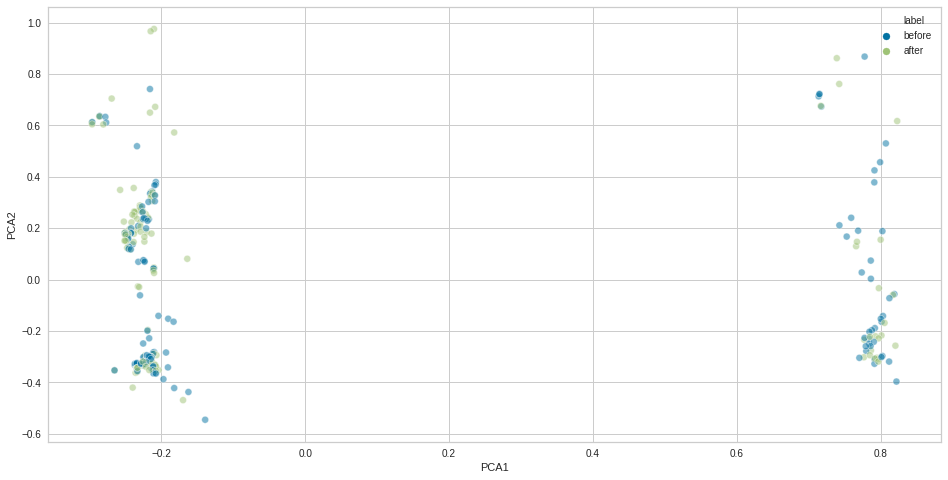

In [3]:
pca = PCA(n_components = 2, )

components_df = pd.DataFrame(pca.fit_transform(labeled_df.drop(["node", "label"], axis=1)),
                            columns=["PCA1", "PCA2"])

components_df['label'] = labeled_df['label']

# components_df = components_df[components_df.PCA1 > 0.2]

# components_df.label.value_counts()

plt.figure(figsize=(16,8))
sns.scatterplot(data=components_df, x="PCA1", y='PCA2', hue='label', alpha=0.5)

# Test Train Split

In [55]:
X = labeled_df.drop([
    "node", 
    "label", 
    "similarity_rank",
    
    # trimming less valuable estimators
    "shortest_path_length_to_entry",
    "primary_link",
    "category_matches_with_source",
    "shortest_path_length_from_entry",
#     "in_edges",
#     "adjusted_reciprocity",
    
], axis=1)
y = labeled_df.label

cols = X.columns 

# class imbalance
ros = RandomOverSampler()
rus = RandomUnderSampler()
smote = SMOTE()

#################
# UNDERSAMPLING #
#################
# X, y = rus.fit_sample(X, y)

# X = pd.DataFrame(X, columns=cols)
# y = pd.Series(y)

#########
# SMOTE #
#########
X, y = smote.fit_sample(X, y)
X = pd.DataFrame(X, columns=cols)
y = pd.Series(y)

# basic train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

################
# OVERSAMPLING #
################
# X_train, y_train = ros.fit_sample(X_train, y_train)
# X_train = pd.DataFrame(X_train, columns=cols)
# y_train = pd.Series(y_train)

# X_test, y_test = ros.fit_sample(X_test, y_test)
# X_test = pd.DataFrame(X_test, columns=cols)
# y_test = pd.Series(y_test)


# # Full data
# X_train = X
# y_train = y

print("Train Classes:")
print(y_train.value_counts(), "\n")
print("Test Classes:")
print(y_test.value_counts(), "\n")

Train Classes:
before    113
after     111
dtype: int64 

Test Classes:
after     29
before    27
dtype: int64 



# Random Forest

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished


Best Params:	 {'bootstrap': True, 'criterion': 'gini', 'max_depth': 2, 'max_leaf_nodes': 8, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 100} 


              precision    recall  f1-score   support

       after       0.75      0.72      0.74        29
      before       0.71      0.74      0.73        27

    accuracy                           0.73        56
   macro avg       0.73      0.73      0.73        56
weighted avg       0.73      0.73      0.73        56

Train Score:	 0.7321428571428571
Test Score:	 0.7321428571428571


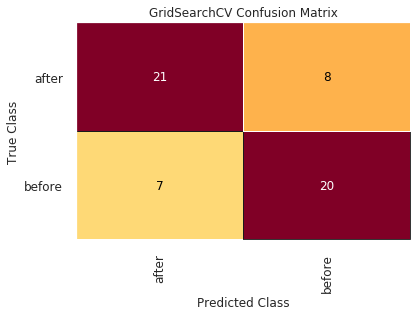

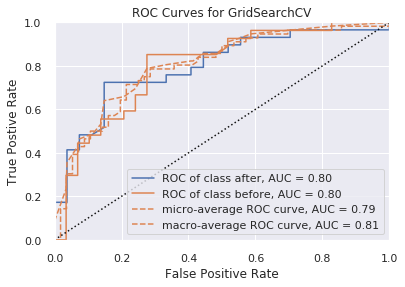

In [56]:
rf = RandomForestClassifier(n_jobs=-1, random_state=42)

# GridSearch params
params = {
#     "pca__n_components": [4,5,6,7,8,9],
    
    "criterion": ["gini"], # entropy
    "n_estimators": [100], # 100
    "max_depth": [2], # 10
    "min_samples_split": [5], # 5
    "min_samples_leaf": [10], # 10
    "max_leaf_nodes": [8], # 8
    "bootstrap": [True]
    
}

rf_model = GridSearchCV(rf, params, n_jobs=-1, cv=3, verbose=2)

rf_model.fit(X_train, y_train)

y_preds = rf_model.predict(X_test)

cm = ConfusionMatrix(rf_model, classes=rf_model.classes_, is_fitted=True)
visualizer = ROCAUC(rf_model, classes=rf_model.classes_, is_fitted=True)

print("Best Params:\t", rf_model.best_params_, "\n\n")
print(classification_report(y_test, y_preds, target_names=rf_model.classes_))
print("Train Score:\t", rf_model.score(X_train, y_train))
print("Test Score:\t", cm.score(X_test, y_test))

cm.poof()

visualizer.score(X_test, y_test)
visualizer.poof()

Saving model with pickle

In [63]:
with open("../models/rf_classifier_v2.pkl", "wb") as model:
    pickle.dump(rf_model.best_estimator_, model,)

In [20]:

best_estimators = pd.DataFrame(list(zip(X_train.columns, rf_model.best_estimator_.feature_importances_)), 
             columns=["Feature", "Estimation Strength"])

best_estimators.sort_values("Estimation Strength", ascending=False)

,Feature,Estimation Strength
5,page_rank,0.242309
0,degree,0.134862
1,in_edges,0.122985
2,out_edges,0.120829
6,adjusted_reciprocity,0.106816
3,shared_neighbors_with_entry_score,0.102482
4,centrality,0.096086
7,jaccard_similarity,0.073631


# XG Boost

Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Train Score:	 0.7678571428571429
Test Score:	 0.7321428571428571


[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.4s finished


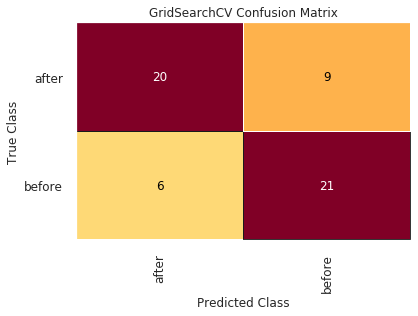

Best Params:	 {'gamma': 1, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


In [57]:
model = XGBRFClassifier(random_state=10, )

params = { 
    "max_depth": [3],
    "n_estimators": [100, 200],
    "learning_rate": [0.01],
    "gamma": [1]
}

xg_model = GridSearchCV(model, params, n_jobs=-1, cv=3, verbose=2)

xg_model.fit(X_train, y_train)

cm = ConfusionMatrix(xg_model, classes=["after", "before"], is_fitted=True)

print("Train Score:\t", xg_model.score(X_train, y_train))
print("Test Score:\t", cm.score(X_test, y_test))
cm.poof()
print("Best Params:\t", xg_model.best_params_)

# SVM

Fitting 10 folds for each of 384 candidates, totalling 3840 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 2616 tasks      | elapsed:    2.6s


0.5357142857142857


[Parallel(n_jobs=-1)]: Done 3840 out of 3840 | elapsed:    3.7s finished
/home/qdizon/.local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/qdizon/.local/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


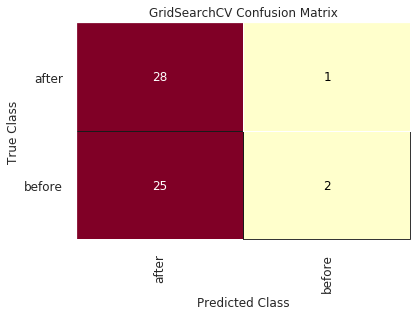

In [58]:
pca = PCA()
model = SVC()

steps = [
    ("pca", pca),
    ("svm", model)
]

pipe = Pipeline(steps)

params = {
    "pca__n_components": [2,3,4,5], 
    
    "svm__C": [0.001, 0.01, 0.1, 1, 10, 15],
    "svm__kernel": ['linear', 'poly', 'rbf', 'sigmoid'],
    "svm__decision_function_shape": ['ovo', 'ovr'],
    "svm__shrinking": [True, False]
}

svc_model = GridSearchCV(pipe, params, n_jobs=-1, cv=10, verbose=2)

cm = ConfusionMatrix(svc_model, classes=["after", "before"])
cm.fit(X_train, y_train)

print(cm.score(X_test, y_test))

cm.poof()

# KNN

Fitting 3 folds for each of 176 candidates, totalling 528 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 528 out of 528 | elapsed:    6.1s finished
/home/qdizon/.local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.5178571428571429


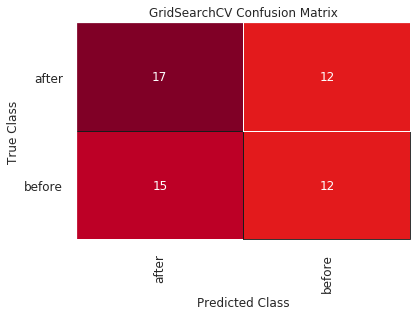

In [59]:
pca = PCA()
knn = KNeighborsClassifier(n_jobs=-1,)

steps = [
    ("pca", pca),
    ("knn", knn)
]

pipe = Pipeline(steps)

params = {
    "pca__n_components": [2,3,4,5], 
    
    "knn__n_neighbors": [k for k in range(5, 26) if k % 2 != 0],
    "knn__metric": ['minkowski', "euclidean", "chebyshev", "wminkowski"]
}

knn_model = GridSearchCV(pipe, params, n_jobs=-1, cv=3, verbose=2, scoring="accuracy", error_score=0.0)

cm = ConfusionMatrix(knn_model, classes=["after", "before"])
cm.fit(X_train, y_train)

print(cm.score(X_test, y_test))

cm.poof()

Best Params:	 {'priors': [0.5, 0.5]} 


Train Score:	 0.5401785714285714
Test Score:	 0.5714285714285714


/home/qdizon/.local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


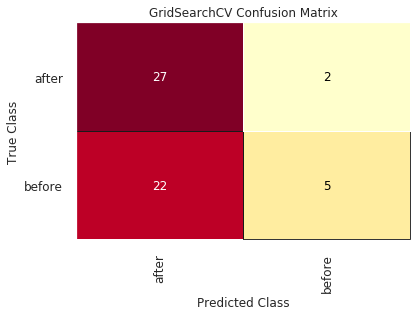

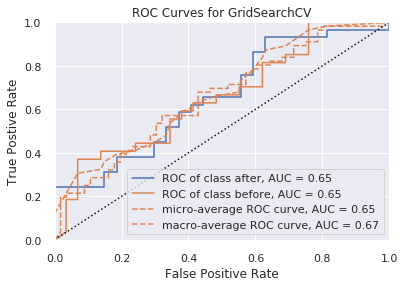

In [60]:
nb = GaussianNB()

params = {
    "priors": [[0.5, 0.5]],
}

nb_model = GridSearchCV(nb, param_grid=params, cv=3)

nb_model.fit(X_train, y_train)

cm = ConfusionMatrix(nb_model, classes=["after", "before"], is_fitted=True)
visualizer = ROCAUC(nb_model, classes=["after", "before"], is_fitted=True)


print("Best Params:\t", nb_model.best_params_, "\n\n")
print("Train Score:\t", nb_model.score(X_train, y_train))
print("Test Score:\t", cm.score(X_test, y_test))
cm.poof()


visualizer.score(X_test, y_test)
visualizer.poof()